In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [232]:
# Read in scores and convert to activity scores
"""
my_store = pd.HDFStore('2017.07.24_Radicicol_exp.h5')
myStoreKeys = my_store.keys()

pointMuts = my_store.select('/main/synonymous/scores')[2:]    # Dropped _sy and _wt (what is _sy?)
idx = [',' not in name for name in pointMuts.index.tolist()] 
pointMuts = pointMuts[idx]
pointMuts = pointMuts[pointMuts['Radicicol', 'score'].notna() & pointMuts['Zero', 'score'].notna()]
pointMuts['Radicicol_score'] = pointMuts['Radicicol', 'score']
pointMuts['Zero_score'] = pointMuts['Zero', 'score']
pointMuts = pointMuts.drop(columns = ['Radicicol', 'Zero'])
pointMuts.columns = [col[0] for col in pointMuts.columns]
pointMuts *= -1
pointMuts.to_csv('pointMuts_scores.csv')
"""
pointMuts = pd.read_csv('pointMuts_scores.csv', index_col = 0)

In [127]:
# Calculating ratios and residuals from activity scores instead of real scores

"""ratios = pointMuts['Radicicol_score'] / pointMuts['Zero_score']

sns.regplot(pointMuts['Radicicol_score'], pointMuts['Zero_score'], scatter_kws = {'alpha':0.25})
[m, b] = np.polyfit(pointMuts['Radicicol_score'], pointMuts['Zero_score'], 1)
zerPointMutsHat = (b + m * pointMuts['Radicicol_score'])
plt.plot(pointMuts['Radicicol_score'], zerPointMutsHat, label = 'y = %fx + %f' %(m, b))
plt.legend()
plt.show()

resids = pointMuts['Zero_score'] - zerPointMutsHat
sns.distplot(resids, label = 'Residuals')
plt.xlabel('Rediduals')
plt.ylabel('Frequency')
plt.title('Residuals of OLS')
plt.show()

resids.to_csv('resids.csv')
ratios.to_csv('ratios.csv')"""

resids = pd.Series.from_csv('resids.csv')
ratios = pd.Series.from_csv('ratios.csv')

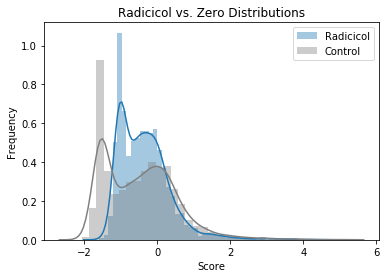

In [128]:
sns.distplot(pointMuts['Radicicol_score'], label='Radicicol')
sns.distplot(pointMuts['Zero_score'], label='Control', color='grey')
plt.legend()
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Radicicol vs. Zero Distributions')
plt.show()

In [129]:
# Constructing lists of 3 letter and 1 letter AA codes to build dictionary and DataFrame
AA3idx = [
    'Ala',
    'Val',
    'Leu',
    'Ile',
    'Met',
    'Phe',
    'Tyr',
    'Trp',
    'Ser',
    'Thr',
    'Asn',
    'Gln',
    'Cys',
    'Asp',
    'Glu',
    'His',
    'Lys',
    'Arg',
    'Gly',
    'Pro',
    'Ter'
]

AA1idx = [
    'A',
    'V',
    'L',
    'I',
    'M',
    'F',
    'Y',
    'W',
    'S',
    'T',
    'N',
    'Q',
    'C',
    'D',
    'E',
    'H',
    'K',
    'R',
    'G',
    'P',
    '*'
]

AAdict = dict(zip(AA3idx, AA1idx))

# Constructing heat maps with ratio and residual values
def makeHeatMap(df):
    muts = df.index.tolist()
    heatMapDF = pd.DataFrame(index = AA1idx, columns = np.arange(270, 520))   # the residue numbers are hard coded here
    for mut in muts:
        heatMapDF.loc[AAdict[mut[8:11]], int(mut[5:8])] = df[mut]
    return(heatMapDF)

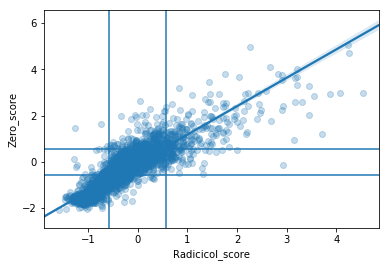

In [130]:
# Plotting GOF, LOF, and WT muts on bivariate plot 

sdRad = 0.2926579180309401
sdZero = 0.28323869489237435

sns.regplot(pointMuts['Radicicol_score'], pointMuts['Zero_score'], scatter_kws = {'alpha':0.25})
plt.axvline(-1.96 * sdRad)
plt.axvline(1.96 * sdRad)
plt.axhline(-1.96 * sdZero)
plt.axhline(1.96 * sdZero)
plt.show()

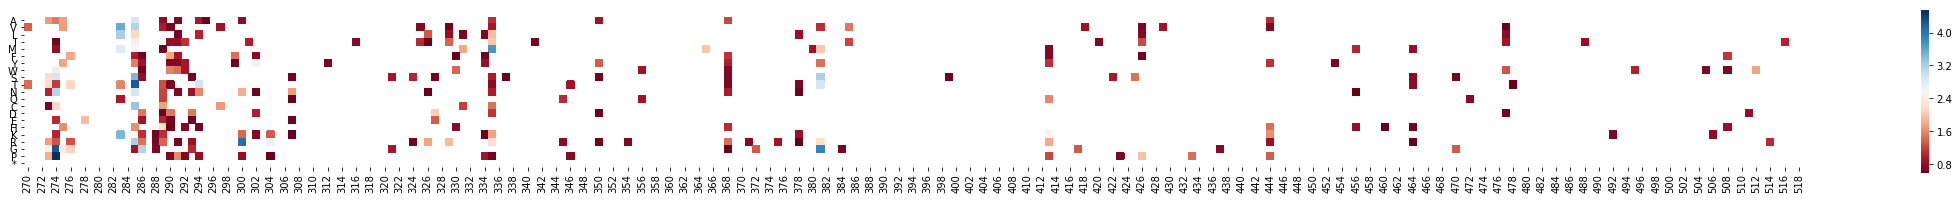

In [131]:
radGOF = pointMuts[pointMuts['Radicicol_score'] > (1.96 * sdRad)]['Radicicol_score']
radGOFMap = makeHeatMap(radGOF)
plt.figure(figsize = (40, 10))
sns.heatmap(radGOFMap.astype(float), mask = radGOFMap.isnull(), square = True, cbar_kws = {"shrink": 0.3}, cmap = "RdBu")
plt.show()

In [132]:
GOFmap = np.zeros(250)
for resid in [int(name[5:8]) for name in radGOF.index.tolist()]:
    GOFmap[resid - 270] += 1

In [133]:
# np.savetxt('./PyMOL/GOFmap.txt',GOFmap)

# 20190127: Finish making heatmaps

Radicicol_score
g


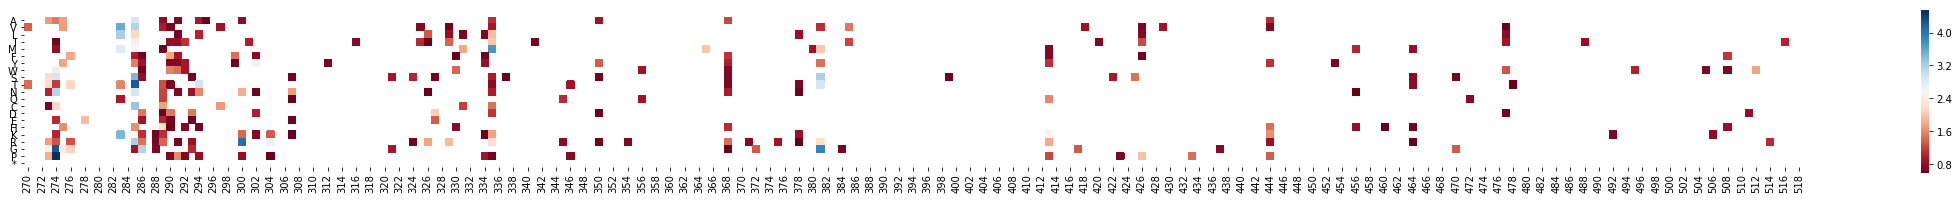

Enter filename: 


IOError: [Errno 21] Is a directory: './PyMOL/'

In [134]:
for condition, stdev in zip(['Radicicol_score', 'Zero_score'], [sdRad, sdZero]):
    for fxnType in ['g', 'l']:
        print(condition)
        print(fxnType)
        if fxnType is 'g':
            fxnDF = pointMuts[pointMuts[condition] > (1.96 * stdev)][condition]
        else:
            fxnDF = pointMuts[pointMuts[condition] < (-1.96 * stdev)][condition]
        plt.figure(figsize = (40,10))
        fxnMap = makeHeatMap(fxnDF)
        sns.heatmap(fxnMap.astype(float), mask = fxnMap.isnull(), square = True, cbar_kws = {"shrink": 0.3}, cmap = "RdBu")
        plt.show()
        

        txtMap = np.zeros(250)
        for resid in [int(name[5:8]) for name in fxnDF.index.tolist()]:
            txtMap[resid - 270] += 1
        filePath = './PyMOL/' + raw_input("Enter filename: ")
        np.savetxt(filePath, txtMap)

# 20190129: Hierarchical Clustering of Residuals

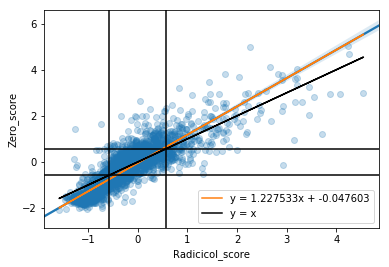

In [135]:
# Should we use line of best fit or line y = x?
[m, b] = np.polyfit(pointMuts['Radicicol_score'], pointMuts['Zero_score'], 1)
zerPointMutsHat = (b + m * pointMuts['Radicicol_score'])
sns.regplot(pointMuts['Radicicol_score'], pointMuts['Zero_score'], scatter_kws = {'alpha':0.25})
plt.plot(pointMuts['Radicicol_score'], zerPointMutsHat, label = 'y = %fx + %f' %(m, b))
plt.plot(pointMuts['Radicicol_score'],pointMuts['Radicicol_score'], color='k', label = 'y = x')
plt.axvline(-1.96 * sdRad, color = 'k')
plt.axvline(1.96 * sdRad, color = 'k')
plt.axhline(-1.96 * sdZero, color = 'k')
plt.axhline(1.96 * sdZero, color = 'k')
plt.legend()
plt.show()

In [187]:
# Making a PyMOL map for y = x residuals
yxResids = pointMuts['Zero_score'] - pointMuts['Radicicol_score']
sdyx = np.std(yxResids)
meanyx = np.mean(yxResids)
yxL = yxResids[yxResids < (meanyx - 1.96 * sdyx)]
yxH = yxResids[yxResids > (meanyx + 1.96 * sdyx)]
yxout = yxL + yxH
txtMap = np.zeros(250)
for resid in [int(name[5:8]) for name in yxout.index.tolist()]:
    txtMap[resid - 270] += 1
np.savetxt('./PyMOL/yxout.txt', txtMap)

In [191]:
my_store = pd.HDFStore('2017.07.24_Radicicol_exp.h5')
myStoreKeys = my_store.keys()
# pointMuts = my_store.select('/main/synonymous/scores_shared_full')[2:]

In [193]:
# pointMuts.to_csv('./fullscores.csv')


# 20190130: Hierarchical Clustering and Log Ratio Metric

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


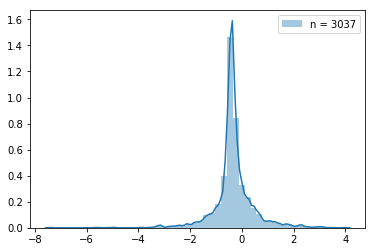

In [217]:
# Taking the log of the ratios radicicol / zero
logRatios = np.log(ratios).dropna()
sns.distplot(logRatios, label = 'n = %d' %len(logRatios))
plt.legend()
plt.show()

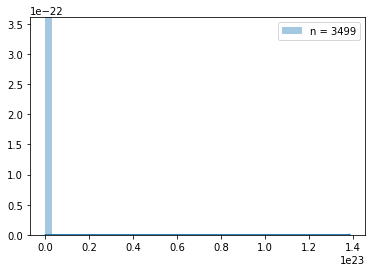

In [222]:
# Taking the exponential of the ratios
expRatios = np.exp(ratios)
sns.distplot(expRatios, label = 'n = %d' %len(expRatios))
plt.legend()
plt.show()

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


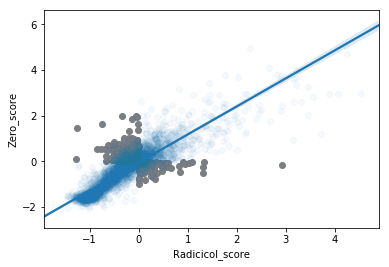

In [238]:
# Which variants don't have the same behavior across treatments
idx = [np.isnan(var) for var in np.log(ratios)]
plt.scatter(pointMuts[idx]['Radicicol_score'], pointMuts[idx]['Zero_score'], color = 'grey')
sns.regplot(pointMuts['Radicicol_score'], pointMuts['Zero_score'], scatter_kws = {'alpha':0.04})
plt.show()

In [289]:
residsHeat = makeHeatMap(resids)

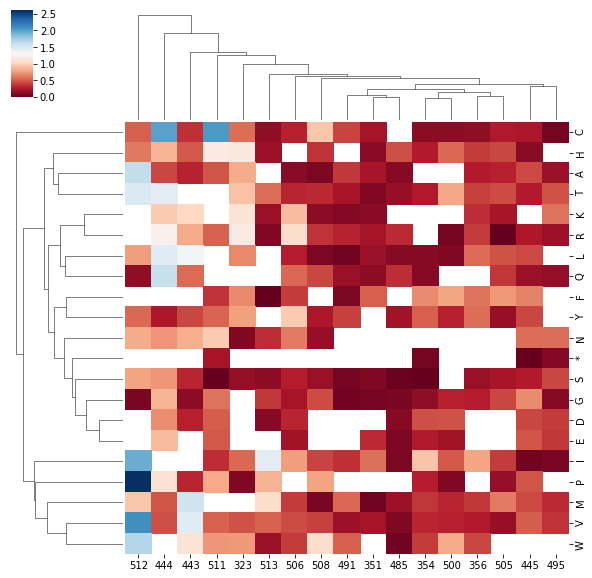

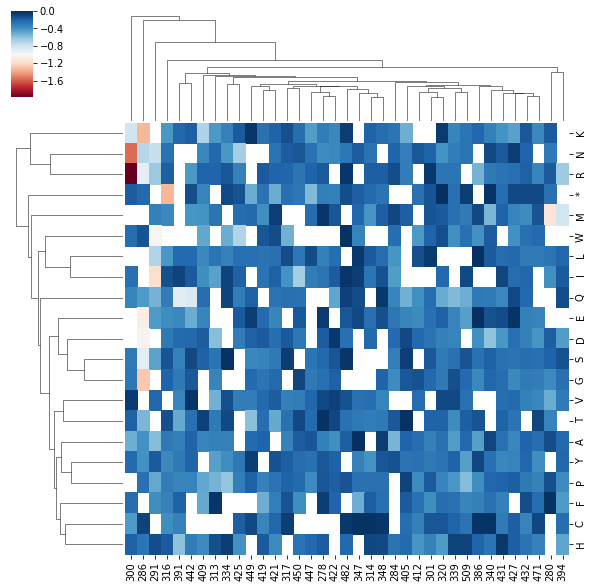

In [294]:
residsHeatPos = residsHeat.where(residsHeat > 0)
residsHeatPos = residsHeatPos.dropna(axis = 1, thresh = 15)
residsHeatPos = residsHeatPos.fillna(0)
sns.clustermap(residsHeatPos, cmap = "RdBu", mask = residsHeatPos == 0.0)
plt.show()

residsHeatNeg = residsHeat.where(residsHeat < 0)
residsHeatNeg = residsHeatNeg.dropna(axis = 1, thresh = 15)
residsHeatNeg = residsHeatNeg.fillna(0)
sns.clustermap(residsHeatNeg, cmap = "RdBu", mask = residsHeatNeg == 0.0)
plt.show()

In [311]:
# Making PyMOL maps for these residue positions
txtMap = np.zeros(250)
for pos in residsHeatNeg.columns.tolist():
    txtMap[pos - 270] = np.mean(residsHeatNeg[pos])
np.savetxt('./PyMOL/residsHeatNeg.txt', txtMap)

txtMap = np.zeros(250)
for pos in residsHeatPos.columns.tolist():
    txtMap[pos - 270] = np.mean(residsHeatPos[pos])
np.savetxt('./PyMOL/residsHeatPos.txt', txtMap)

"np.savetxt('./PyMOL/residsHeatNeg.txt', txtMap)\n\ntxtMap = np.zeros(250)\nfor pos in residsHeatPos.columns.tolist():\n    txtMap[pos - 270] = np.mean(residsHeatPos[pos])\nnp.savetxt('./PyMOL/residsHeatPos.txt', txtMap)"

In [342]:
idx = [int(name[5:8]) == 286 for name in resids.index.tolist()]
pointMuts.loc[idx]

,Radicicol_score,Zero_score
p.Met286Ala,0.461260,0.128726
p.Met286Arg,1.474348,0.872893
p.Met286Asn,0.547082,-0.082127
p.Met286Asp,1.497519,0.774929
p.Met286Cys,0.143391,0.053066
p.Met286Gln,0.560442,0.207579
p.Met286Glu,0.901744,-0.004434
p.Met286Gly,3.168487,2.585769
p.Met286His,0.332788,0.095462
p.Met286Ile,-0.565497,-0.501949


# 20190131: Making a figure for resiudal metric

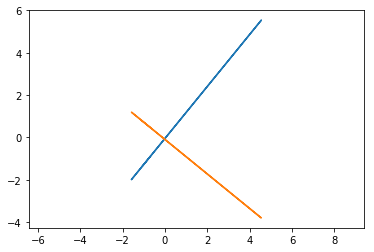

In [385]:
# sns.regplot(pointMuts['Radicicol_score'], pointMuts['Zero_score'], scatter_kws = {'alpha':0.25})
point = pointMuts.loc['p.Val478Tyr']
x1 = point['Radicicol_score']
y1 = point['Zero_score']
[m, b] = np.polyfit(pointMuts['Radicicol_score'], pointMuts['Zero_score'], 1)
b1 = y1 + -(m**-1) * x1
m1 = -m**-1
plt.plot(pointMuts['Radicicol_score'], b + m * pointMuts['Radicicol_score'])
plt.plot(pointMuts['Radicicol_score'], (b1 + m1 * pointMuts['Radicicol_score']))
plt.axis('equal')
plt.show()



In [443]:
[m, b] = np.polyfit(pointMuts['Radicicol_score'], pointMuts['Zero_score'], 1)

def calcNorm(point, a, c):
    """
    a = slope
    c = y-intercept
    """
    x1 = point['Radicicol_score']
    y1 = point['Zero_score']
    b = -a**-1
    d = y1 - b * x1
    x_inter = (d - c) / (a - b)
    y_inter = (a * d - b * c) / (a - b)
    return np.sqrt(((x1 - x_inter)**2) + ((y1 - y_inter)**2))




euclideanResids = pd.Series(index = pointMuts.index.tolist())
for mut in pointMuts.index.tolist():
    euDist = calcNorm(pointMuts.loc[mut], m, b)
    pred = b + m * pointMuts.loc[mut]['Radicicol_score'] - pointMuts.loc[mut]['Zero_score']
    if pred > 0:
        euDist *= -1
    euclideanResids[mut] = euDist
    


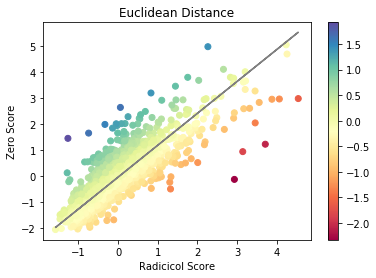

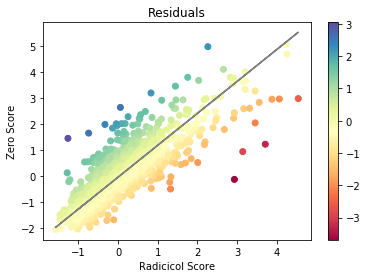

In [447]:
plt.scatter(pointMuts['Radicicol_score'], pointMuts['Zero_score'], c = euclideanResids, cmap = 'Spectral')
plt.colorbar()
plt.plot(pointMuts['Radicicol_score'], c + a * pointMuts['Radicicol_score'], color = 'gray')
plt.ylabel('Zero Score')
plt.xlabel('Radicicol Score')
plt.title('Euclidean Distance')
plt.show()

plt.scatter(pointMuts['Radicicol_score'], pointMuts['Zero_score'], c = resids, cmap = 'Spectral')
plt.colorbar()
plt.plot(pointMuts['Radicicol_score'], c + a * pointMuts['Radicicol_score'], color = 'gray')
plt.ylabel('Zero Score')
plt.xlabel('Radicicol Score')
plt.title('Residuals')
plt.show()

# 20190201: Residual figures, more data analysis

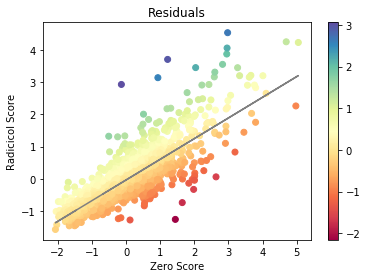

In [454]:
[a, c] = np.polyfit(pointMuts['Zero_score'], pointMuts['Radicicol_score'], 1)
radHat = c + a * pointMuts['Zero_score']
residsNew = pointMuts['Radicicol_score'] - radHat
plt.scatter(pointMuts['Zero_score'], pointMuts['Radicicol_score'], c = residsNew, cmap = 'Spectral')
plt.colorbar()
plt.plot(pointMuts['Zero_score'], c + a * pointMuts['Zero_score'], color = 'gray')
plt.ylabel('Radicicol Score')
plt.xlabel('Zero Score')
plt.title('Residuals')
plt.show()
# residsNew.to_csv('residsNew.csv')

In [480]:
# Average residual per position and the standard deviation of those residuals
residAnal = pd.DataFrame(index = np.arange(270, 270 + 250), columns = ['WTaa', 'Residuals', 'Mean Residual', 'SD Residual'])

muts = residsNew.index.tolist()

for mut in muts:
    resn = int(mut[5:8])
    residAnal.loc[resn]['WTaa'] = mut[2:5]
    if residAnal.loc[resn]['Residuals'] is np.nan:
        residAnal.loc[resn]['Residuals'] = []
    residAnal.loc[resn]['Residuals'].append(residsNew[mut])
    
for res in residAnal.index.tolist():
    residAnal.loc[res]['Mean Residual'] = np.mean(residAnal.loc[res]['Residuals'])
    residAnal.loc[res]['SD Residual'] = np.std(residAnal.loc[res]['Residuals'])


,WTaa,Residuals,Mean Residual,SD Residual
270,Leu,"[0.11189851516, -0.0122192454741, 0.1377754851...",0.378043,0.428918
271,Arg,"[0.0361623704485, 0.13952563142, 0.33490864369...",0.0957603,0.20959
272,NaN,NaN,NaN,NaN
273,Glu,"[0.947447502465, 1.19198204152, 0.615291885943...",0.330423,0.706462
274,Val,"[0.359863936671, 0.424538465288, 2.58362902254...",0.853566,0.817189
275,Lys,"[0.120196614329, -0.0681508937087, -0.36410800...",0.21709,0.445606
276,Leu,"[1.50171188729, -0.617473141958, 0.30349233738...",0.47731,0.600892
277,Gly,"[0.528490451786, 0.0483098531261, -0.072070567...",0.172513,0.306184
278,Gln,"[0.372042884303, 0.0690388548539, 0.2295692586...",0.118654,0.140824
279,Gly,"[0.0981029621784, -0.193576160364, -0.03087600...",-0.018818,0.0946632


In [488]:
residAnal.loc[274]

WTaa                                                           Val
Residuals        [0.359863936671, 0.424538465288, 2.58362902254...
Mean Residual                                             0.853566
SD Residual                                               0.817189
Name: 274, dtype: object

In [484]:
txtMap = np.zeros(250)
for pos in residAnal.index.tolist():
    txtMap[pos - 270] = residAnal.loc[pos]['Mean Residual']
np.savetxt('./PyMOL/residMean.txt', txtMap)

txtMap = np.zeros(250)
for pos in residAnal.index.tolist():
    txtMap[pos - 270] = residAnal.loc[pos]['SD Residual']
np.savetxt('./PyMOL/residSD.txt', txtMap)

In [486]:
residAnal.loc[400]

WTaa                          Asn
Residuals        [-1.32055563838]
Mean Residual            -1.32056
SD Residual                     0
Name: 400, dtype: object

# 20190206: Unbiased exploratory analysis

In [501]:
# Looking at tails of distribution
meanResid = np.mean(residsNew) # -1.871101793716647e-16
SDResid = np.std(residsNew)    # 0.3245443316967276
residLow = residsNew[residsNew < (meanResid - 1.96 * SDResid)] # 68 mutants
residHigh = residsNew[residsNew > (meanResid + 1.96 * SDResid)] # 121 mutants
tailResids = residLow.append(residHigh)

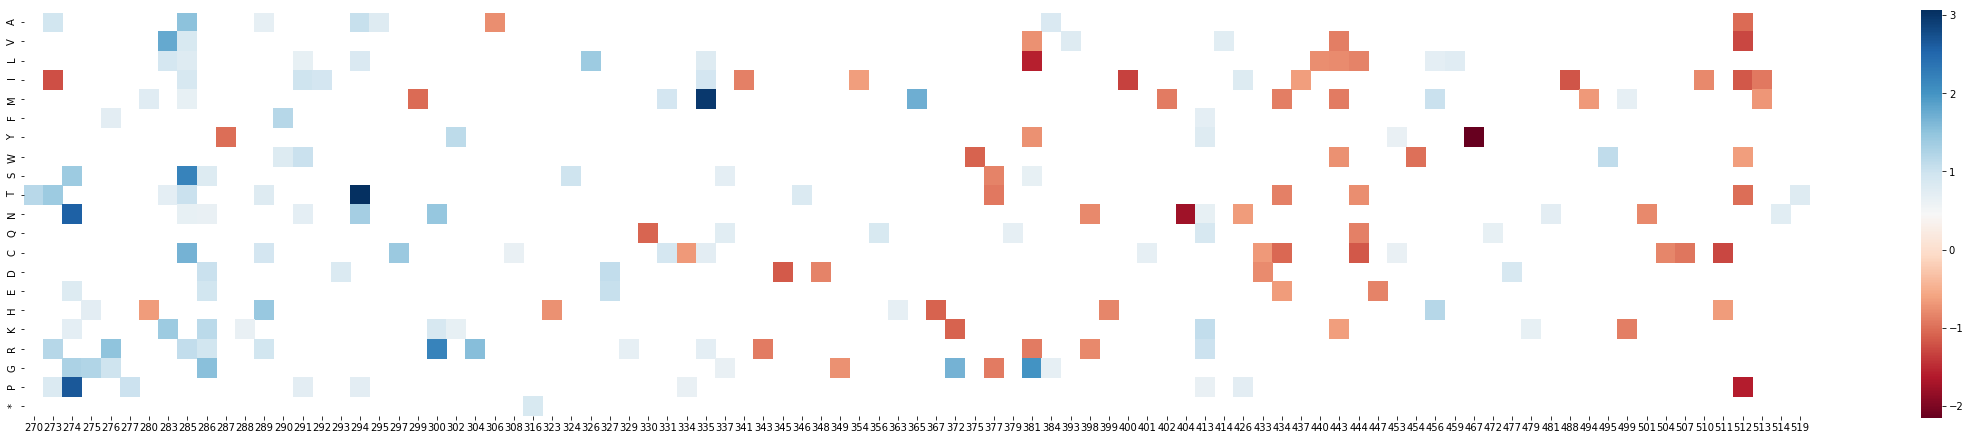

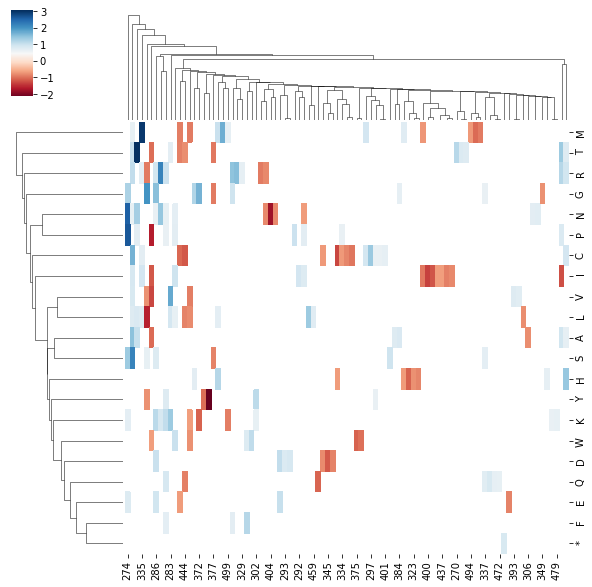

In [531]:
tailResidsMap = makeHeatMap(tailResids)
tailResidsMap = tailResidsMap.dropna(axis = 1, how = 'all')

txtMap = np.zeros(250)
for pos in tailResidsMap.columns.tolist():
    txtMap[pos - 270] = np.nanmean(tailResidsMap[pos])
np.savetxt('./PyMOL/tailResidsMap.txt', txtMap)

tailResidsMap = tailResidsMap.fillna(0.0)


plt.figure(figsize = (40, 10))
sns.heatmap(tailResidsMap, cmap = "RdBu", mask = tailResidsMap == 0.0, square = True, cbar_kws = {"shrink": 0.75})
plt.show()


sns.clustermap(tailResidsMap, cmap = "RdBu", mask = tailResidsMap == 0.0)
plt.show()

In [529]:
np.nanmean(tailResidsMap[271])

AttributeError: 'int' object has no attribute 'dtype'

In [530]:
tailResidsMap

,270,271,272,273,274,275,276,277,278,279,...,510,511,512,513,514,515,516,517,518,519
A,NaN,NaN,NaN,0.947448,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-1.01504,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-1.29891,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
I,NaN,NaN,NaN,-1.23141,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.805695,NaN,-1.17028,-0.932289,NaN,NaN,NaN,NaN,NaN,NaN
M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.689517,NaN,NaN,NaN,NaN,NaN,NaN
F,NaN,NaN,NaN,NaN,NaN,NaN,0.737742,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.646504,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S,NaN,NaN,NaN,NaN,1.40864,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T,1.1706,NaN,NaN,1.39115,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.998346,NaN,NaN,NaN,NaN,NaN,NaN,0.789331
